(demo_notebooks:measurement:intensity_on_vectors)=

# Measureing intensity on vectors and surfaces

Often, we want to measure the intensity of a signal on a vector or surface. This can be done using the measure_intensity_on_vectors() function. This function takes a vector or surface as input and returns the intensity of the signal on the vector or surface.

In [1]:
from napari_stress import vectors, sample_data, measurements, frame_by_frame
import napari
import numpy as np
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import napari_process_points_and_surfaces as nppas

## Segmentation of sample data

We use [napari-segment-blobs-and-things-with-membranes](https://www.napari-hub.org/plugins/napari-segment-blobs-and-things-with-membranes) to segment the sample data. By using the `frame_by_frame` option, we can segment each frame individually without having to write for-loops. 

In [2]:
droplet = sample_data.get_droplet_4d()[0][0]

In [3]:
droplet_rescaled = frame_by_frame(nsbatwm.rescale)(droplet, scale_x=1, scale_y=1, scale_z=2)
droplet_binary = frame_by_frame(nsbatwm.threshold_otsu)(droplet_rescaled)

## Create surface

To create a surface from the rescaled and binarized droplet data, we use [napari-process-points-and-surfaces](https://www.napari-hub.org/plugins/napari-process-points-and-surfaces), which provides the marching-cubes algorithm to create a surface from a binary image.

In [4]:
surface = frame_by_frame(nppas.label_to_surface)(droplet_binary, 1)
surface_smooth = frame_by_frame(nppas.smooth_surface)(surface)

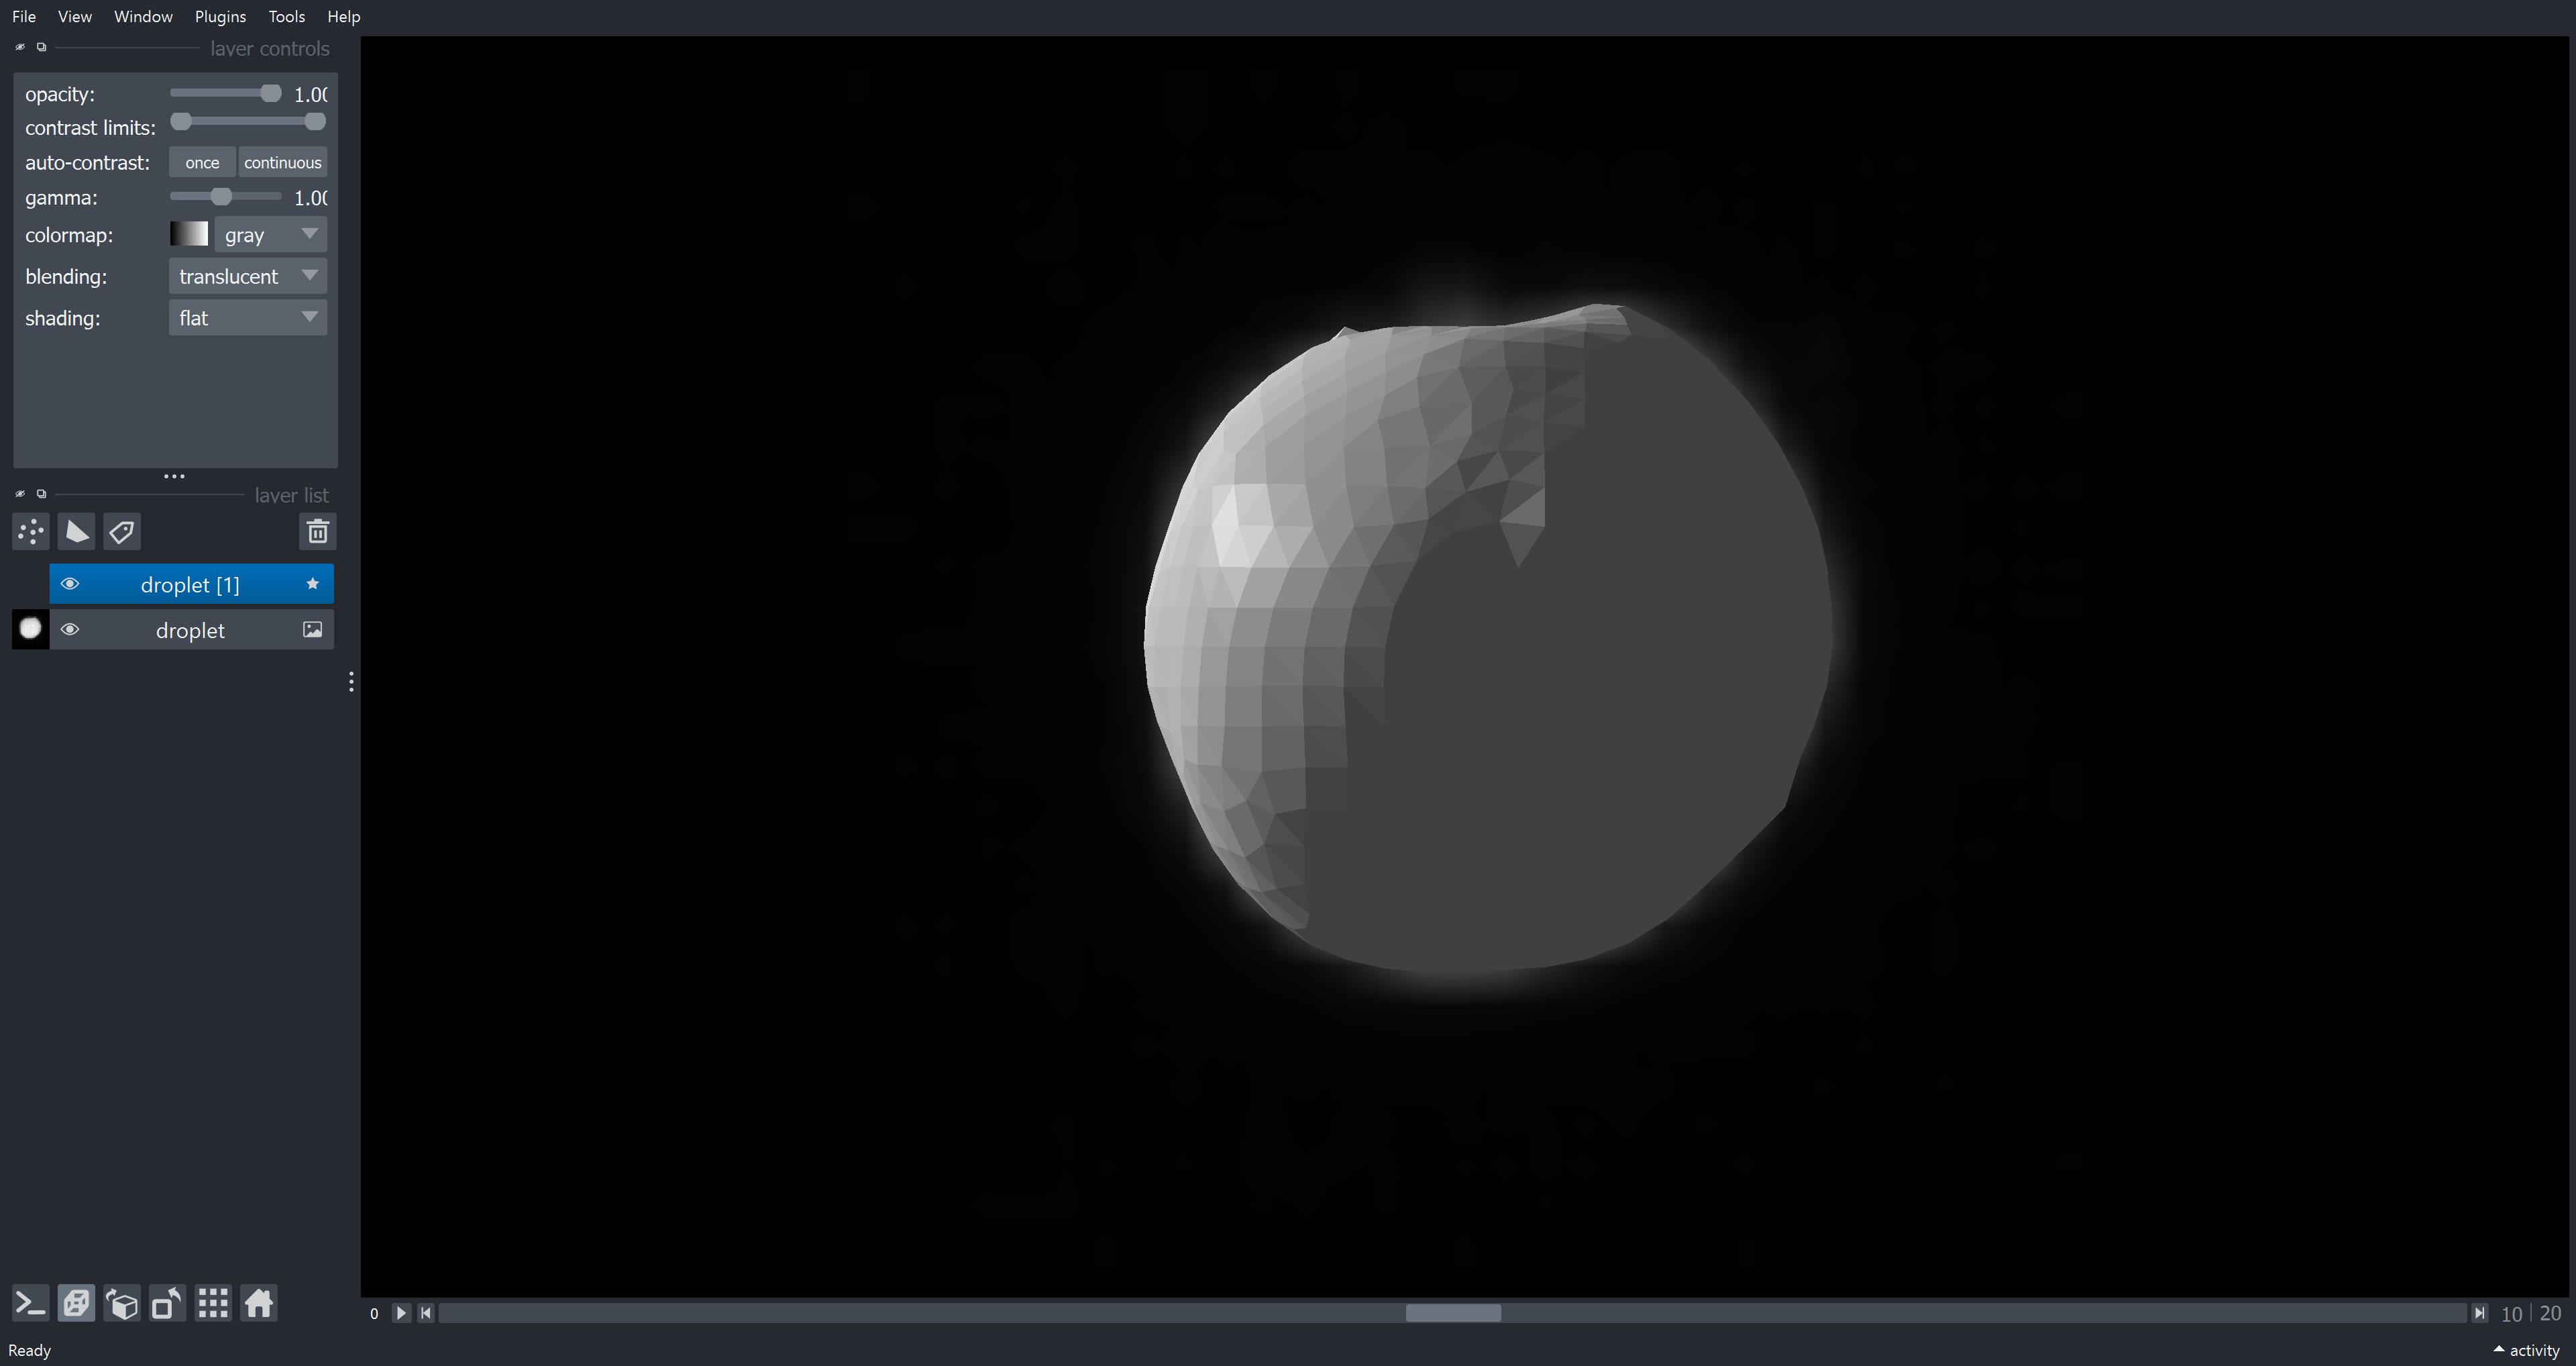

In [5]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(droplet_rescaled, name="droplet")
viewer.add_surface(surface_smooth, name="droplet")
napari.utils.nbscreenshot(viewer)

## Measureing intensity

We now calculate the surface normals of the surface and use them to measure the intensity of the signal on the surface. To be able to measure intensity in a rregion around the surface, we can pass the `length_multiplier` value to the function, which will create a vector with the length of the surface normal multiplied by the `length_multiplier` value. The intensity of the signal on the vector is then measured.

Moreover, the `center` parameter determines whether the vector is centered on the surface or not. If `center` is set to `True`, the vector is centered on the surface. If `center` is set to `False`, the vector can point outwards or inwards, depending on the sign of the `length_multiplier` parameter.

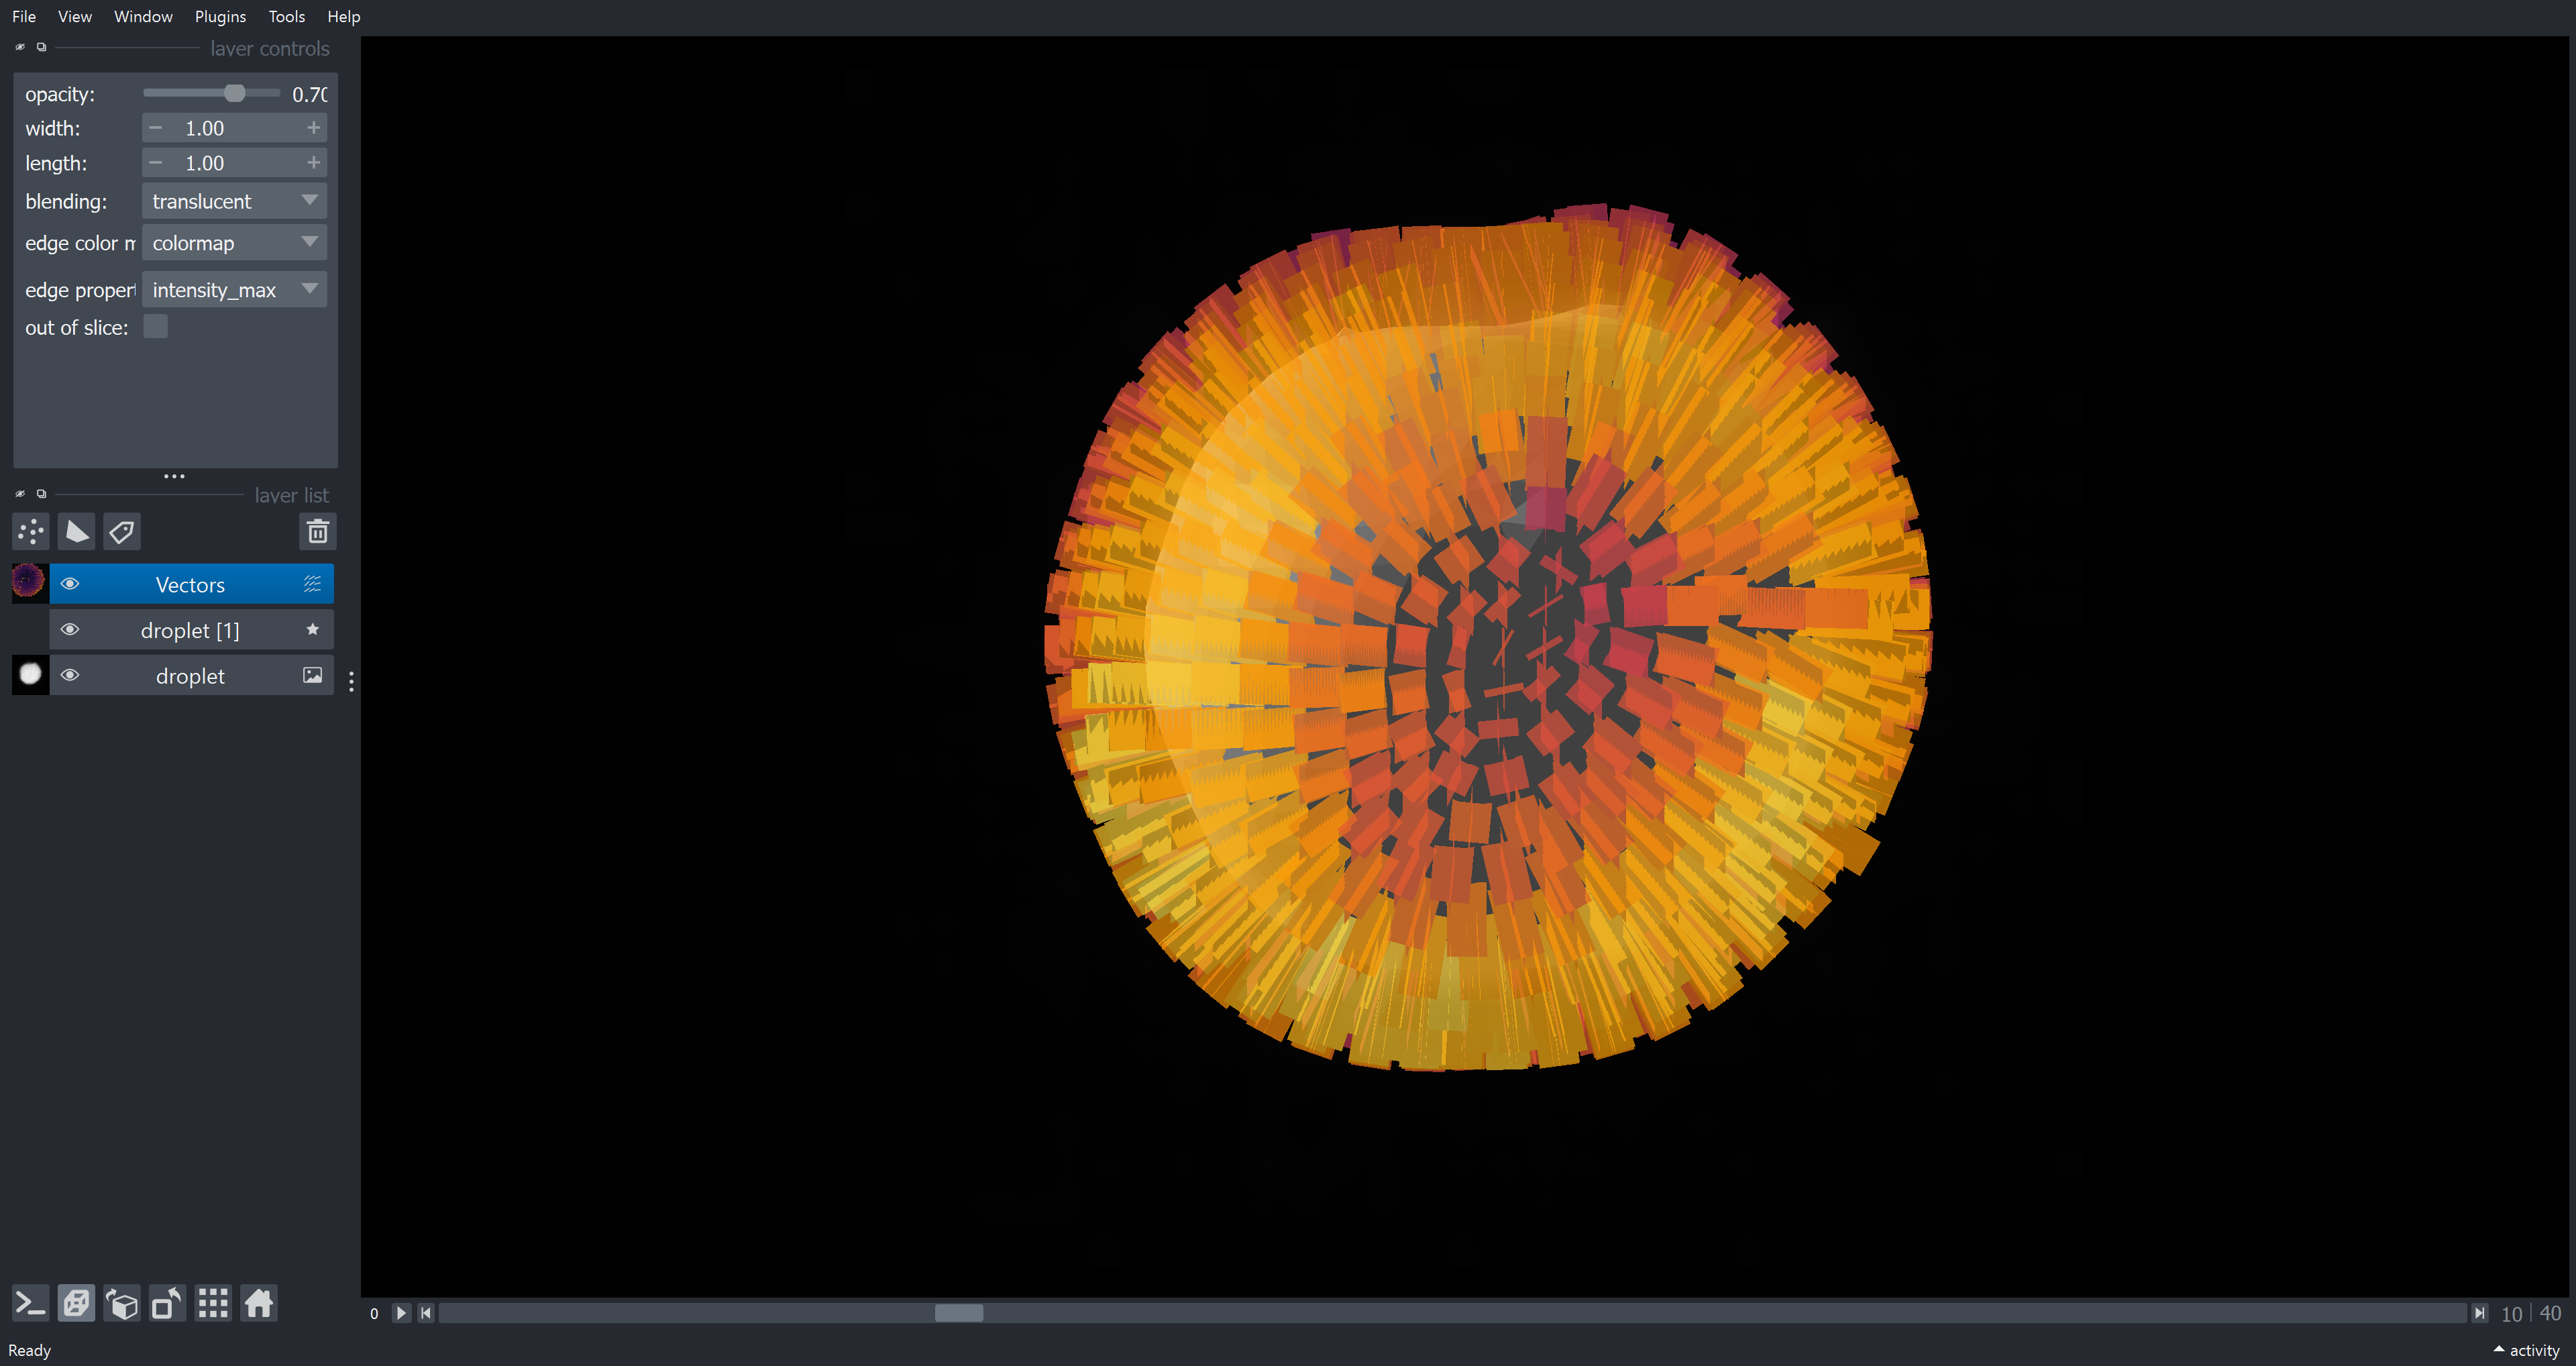

In [6]:
normals = vectors.normal_vectors_on_surface(surface_smooth, length_multiplier=5, center=True)
vectors_LDtuple = measurements.intensity._sample_intensity_along_vector(normals, droplet_rescaled)

layer = napari.layers.Layer.create(vectors_LDtuple[0], vectors_LDtuple[1], vectors_LDtuple[2])
vector_layer = viewer.add_layer(layer)

napari.utils.nbscreenshot(viewer)

## Projecting vector measurements on surface

Lastly, we can project the vector measurements on the surface. The measurements are stored in a `features` table that is attached to the last added vectors layer:

In [7]:
viewer.layers[-1].features.head()

step_0      step_1     step_2     step_3     step_4  intensity_mean  \
0  163.143768  119.508354  70.187156  36.135386  20.747821       81.944497   
1  166.786490  124.618316  71.018596  37.731357  23.359034       84.702758   
2  175.819763  138.049967  81.683062  39.697817  16.711681       90.392458   
3  172.347860  138.653992  80.542078  39.854559  18.776891       90.035076   
4  160.743460  118.354990  68.113843  33.601110  19.586847       80.080050   

   intensity_std  intensity_max  intensity_min  
0      59.131438     163.143768      20.747821  
1      60.182248     166.786490      23.359034  
2      66.414832     175.819763      16.711681  
3      64.855847     172.347860      18.776891  
4      59.022170     160.743460      19.586847

To colour the surface according to either of these measurements, we can simply do so by the following lines of code: 

In [8]:
values_to_visualize = viewer.layers[-1].features['intensity_max'].values
new_surface_tuple = (surface_smooth[0], surface_smooth[1], values_to_visualize)

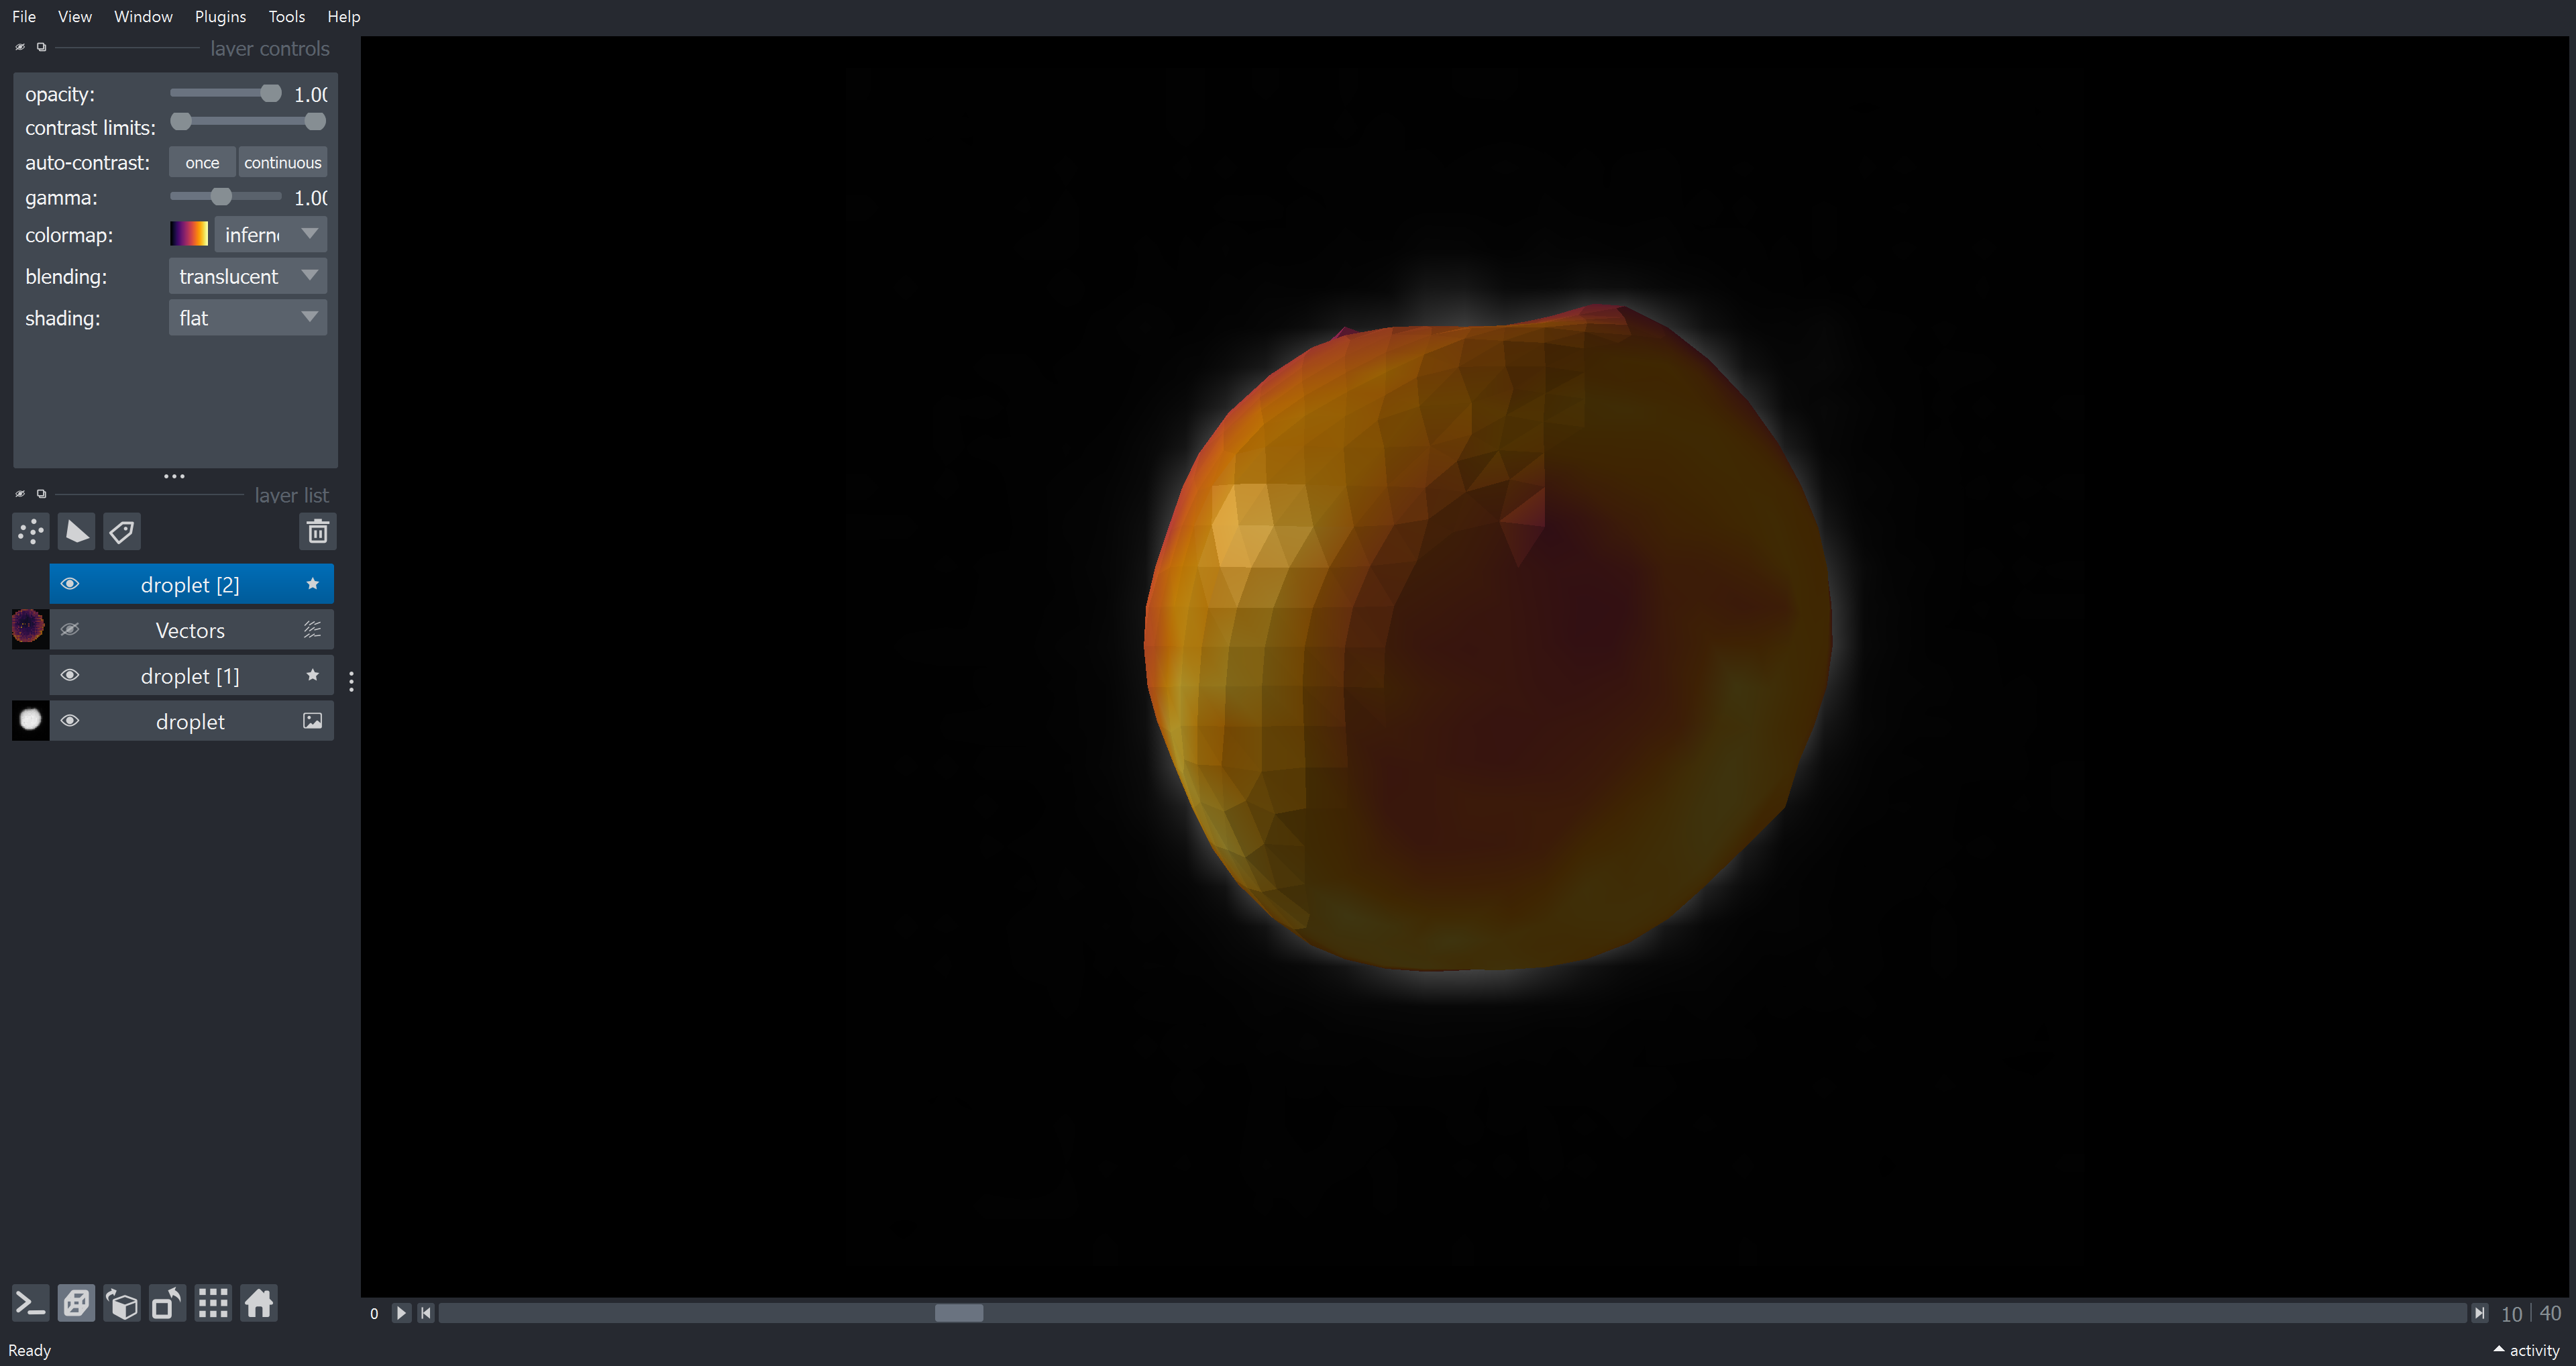

In [9]:
vector_layer.visible = False
viewer.add_surface(new_surface_tuple, name="droplet", colormap='inferno')
napari.utils.nbscreenshot(viewer)